In [15]:
from PIL import Image
from boundbox import BoundBox
import pytesseract
import re
from copy import deepcopy
import json

# If you don't have tesseract executable in your PATH, include the following:
pytesseract.pytesseract.tesseract_cmd = r'E:\Program Files\Tesseract-OCR\tesseract'


# Example tesseract_cmd = r'C:\Program Files (x86)\Tesseract-OCR\tesseract'

class AnnotationTool:
    def __init__(self, ocr_path=None,vocab=None):
        if ocr_path:
            pytesseract.pytesseract.tesseract_cmd = ocr_path
        if vocab:
            f = open(vocab)
            self.vocab = json.load(f)
        self.data_types = {'date' : 'number','r_number':'text','client_name':'text','total_amount' : 'number','salesperson':'text'}
        self.y_threshold = 5
        self.x_threshold = 50

    def ocr(self, image, merge=False):
        data = pytesseract.image_to_data(Image.open(path), output_type=pytesseract.Output.DICT)

        temp_bounds = BoundBox.pytesseract_boxes(data)
        cleaned_bounds = self.clean_ocr(temp_bounds)
        if merge:
            cleaned_bounds = BoundBox.merge_box(cleaned_bounds, dx=0.5, vx=0, merge_box_inside=False)
        return cleaned_bounds

    def search_by_vocab(self, bounds,name):
        founded = []
        for b in bounds:
            if any([word.lower() in b.text_value.lower() for word in self.vocab[name]]):
                founded.append(b)
        return founded
                
    def check_valid(self, text, return_text=False,value_type=None):
        if value_type == 'number':
            text = text.replace(".","").replace(",","").replace(":","").replace("/","")
            pattern = re.compile("[0-9]+")
            res = pattern.search(text)
            if return_text:
                if res:
                    return text
                else:
                    return False
            if res:
                if len(res[0]) < 1:
                    return False
        elif value_type == 'text':
            pattern = re.compile("[a-zA-Z]+")
            res = pattern.search(text)
            if return_text:
                if res:
                    return text
                else:
                    return False
            if res:
                if len(res[0]) < 1:
                    return False
            return True
        else:
            pattern = re.compile("[a-zA-Z0-9]+")
            res = pattern.search(text)
            if return_text:
                if res:
                    return res[0].lower()
                else:
                    return False
            if res:
                if len(res[0]) < 1:
                    return False
            return True
            

    def clean_ocr(self, bounds):
        new_bounds = []
        for b in bounds:
            if len(b.text_value.strip()) < 1:
                continue
            new_bounds.append(b)
        return new_bounds

    def search_bound(self, bounds, x, y,value_type=None):
        bounds = BoundBox.merge_box(bounds,dx=0.5,vx=0,merge_box_inside=False)
        if value_type and value_type in self.data_types:
            value_type = self.data_types[value_type]
        for b in bounds:
            if (b.p1.x - 10 <= x <= b.p2.x + 10) and (b.p1.y - 20 <= y <= b.p4.y + 20) and self.check_valid(
                    b.text_value,value_type=value_type):
                
                return b
        return None

    def find_alternative_key(self, bounds, value_bound):
        options = []
        bounds = BoundBox.merge_box(bounds, dx=0.8, vx=0, merge_box_inside=False)
        # check for left keys
        for bound in bounds:
            if not isinstance(bound, BoundBox) or not isinstance(value_bound, BoundBox):
                continue
            if bound.text_value == value_bound.text_value or bound.p4.y > value_bound.p4.y + self.y_threshold or bound.p1.y < value_bound.p1.y + self.y_threshold:
                continue
            
            if abs(bound.p4.y - value_bound.p1.y) > 80 or bound.p2.x > value_bound.p1.x+10:
                continue
                
            if self.check_valid(bound.text_value) is False:
                continue

            options.append(bound)
        
        if len(options) == 0:
            for bound in bounds:
                if not isinstance(bound, BoundBox) or not isinstance(value_bound, BoundBox):
                    continue
                if bound.text_value == value_bound.text_value or bound.p4.y > value_bound.p4.y + self.y_threshold:
                    continue
                
                if abs(bound.p4.y - value_bound.p1.y) > 80:
                    continue
                
                if self.check_valid(bound.text_value) is False:
                    continue
                candidate_center = int((bound.p1.x + bound.p2.x) / 2)
                if abs(bound.p2.x - value_bound.p1.x) <= self.x_threshold or abs(
                        bound.p1.x - value_bound.p2.x) <= self.x_threshold or \
                        (value_bound.p1.x < candidate_center < value_bound.p2.x):
                    options.append(bound)

#         filtered_options = []
#         for opt in options:
#             cleaned_text = self.check_valid(opt.text_value, return_text=True)
#             if cleaned_text:
#                 opt.text_value = self.check_valid(opt.text_value, return_text=True)
#                 filtered_options.append(opt)
        print("Last ", options)
        if len(options) == 2:
            return BoundBox.merge_box(options, dx=100, vx=200)
        return options

def add_annotation_starter(bounds):
    print("Starter!!!")
    for key in anno.vocab.keys():
        options_for_key = []
        for b in bounds:
            if any([w in b.text_value.lower() for w in anno.vocab[key]]):
                new_tagged_item = dict()
                new_tagged_item['x'] = b.p1.x
                new_tagged_item['y'] = b.p1.y
                new_tagged_item['label'] = key
                new_tagged_item['value'] = b.text_value
                new_tagged_item['width'] = abs(b.p2.x-b.p1.x)
                new_tagged_item['height'] = abs(b.p4.y-b.p1.y)    
                options_for_key.append(new_tagged_item)   
    
    print("End of starter: ", options_for_key)
    return options_for_key
    

def add_annotation(bboxes,starter=False):
    bbox_list = bboxes

    def find_item(bbox_l, val):
        for bb in bbox_l:
            if bb['label'] == val:
                return bb
        return None

    a_bounds = anno.ocr(path, merge=True)
    if starter:
        new_boxes = add_annotation_starter(a_bounds)
        for box in new_boxes:
            bbox_list.append(box)
    value_labels = [item['label'] for item in bbox_list if 'key' not in item['label']]
    keys_labels = [item['label'] for item in bbox_list if 'key' in item['label']]
    
    for v in value_labels:
        if not any([v.replace("_","") in key.replace("_", "") for key in keys_labels]):
            item_bbox = find_item(bbox_list, v)
            item_center_x = item_bbox['x'] + int(item_bbox['width'] / 2)
            item_center_y = item_bbox['y'] + item_bbox['height']
            founded_bound = anno.search_bound(a_bounds, item_center_x, item_center_y,value_type=v)
            print("Founded ", founded_bound)
            if founded_bound is None:
                item_bbox['status'] = 0
                continue
            keys_options = anno.find_alternative_key(a_bounds, founded_bound)
            if len(keys_options) > 0 and keys_options[0] is not None:
#                 center_key_options = (abs(int((keys_options[0].p1.x + keys_options[0].p2.x) / 2)),
#                                       abs(int((keys_options[0].p1.y + keys_options[0].p4.y) / 2)))
                new_tagged_item = dict()
                new_tagged_item['x'] = keys_options[0].p1.x
                new_tagged_item['y'] = keys_options[0].p1.y
                new_tagged_item['label'] = v + "_key"
                new_tagged_item['value'] = keys_options[0].text_value
                new_tagged_item['width'] = abs(keys_options[0].p2.x-keys_options[0].p1.x)
                new_tagged_item['height'] = abs(keys_options[0].p4.y-keys_options[0].p1.y)
                
                bbox_list.append(new_tagged_item)
                item_bbox['value'] = founded_bound.text_value
                item_bbox['x'] = founded_bound.p1.x
                item_bbox['y'] = founded_bound.p1.y
                item_bbox['width'] = abs(founded_bound.p2.x-founded_bound.p1.x)
                item_bbox['height'] = abs(founded_bound.p4.y-founded_bound.p1.y)
    
    return bbox_list


#path = r'E:\Aviv\ocr_project\1_Images\1_Images\20210428_151140.jpg'
path = 'images/10.jpg'
anno = AnnotationTool(vocab='vocab.json')
# a_bounds = anno.ocr(path, merge=True)
# for i, b in enumerate(a_bounds):
#     print(i, b)

# keys_options = anno.find_alternative_key(a_bounds, a_bounds[0])
# print(keys_options)


In [17]:
from jupyter_bbox_widget import BBoxWidget
import ipywidgets as widgets
import os
import json
import base64
import threading,time,random


def encode_image(filepath):
    im = Image.open(filepath)
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded 


testwidget = BBoxWidget(
    image=encode_image('images/10.jpg'),
    classes=['date','r_number','client_name','total_amount','r_number_key','total_amount_key','salesperson','salesperson_key','client_name_key'],
)

# swap positions to trigger rendering seems like its the only way
def swapPositions(list, pos1, pos2):
    first_ele = list.pop(pos1)  
    second_ele = list.pop(pos2-1)
    list.insert(pos1, second_ele) 
    list.insert(pos2, first_ele) 
     
    return list

number_of_boxes = 0
w_out = widgets.Output()
starter = True
# event to handle ocr and annotation changes
def on_bbox_change(change):
    global testwidget,number_of_boxes,starter
    w_out.clear_output(wait=True)
    with w_out:
        if all(['key' in w['label'] for w in change['new']]):
            number_of_boxes+=1
            return True
        bboxes_all = add_annotation(testwidget.bboxes,starter)
        if starter:
            starter = False
        if len(bboxes_all) == number_of_boxes:
            return True
        bboxes_all = [{**bbox} for bbox in bboxes_all]
        number_of_boxes=len(bboxes_all)
        time.sleep(3)
        return render(bboxes_all)

# render function to reload bounding boxes
def render(bboxes):
    global testwidget
    bboxes_all = [{**bbox} for bbox in bboxes]
    if len(bboxes_all) > 1:
        testwidget.bboxes = swapPositions(bboxes_all,0,1)
    
testwidget.observe(on_bbox_change, names=['bboxes'])

w_container = widgets.VBox([
    testwidget,
    w_out,
])

# settings for vocabulary and annotation file
save_path ='output.json'
save_vocab_path = 'vocab.json'
save_vocabs = True
word_vocab = {}


@testwidget.on_submit
def submit():
    global anno
    print("Submit start")
    #image_file = files[w_progress.value]
    for item in testwidget.bboxes:
        if 'key' not in item['label']:
            continue
            
        if item['label'] not in anno.vocab:
            word_vocab[item['label']] = []
            
        if item['value'].lower() in anno.vocab[item['label']]:
            continue
        if 'status' in item and item['status'] != 0:
            anno.vocab[item['label']].append(item['value'].lower())
        else:
            anno.vocab[item['label']].append(item['value'].lower())
    
    # save annotations for current image
    with open(save_path, 'w') as f:
        json.dump(testwidget.bboxes, f, indent=4)
    
    if save_vocabs:
        with open(save_vocab_path, 'w') as f:
            json.dump(anno.vocab, f, indent=4)
    
    print("Saved!")
    # move on to the next file
    #skip()


In [18]:
w_container

In [13]:
testwidget.bboxes

[{'x': 20,
  'y': 18,
  'label': 'r_number_key',
  'value': 'Customer Invoices',
  'width': 186,
  'height': 14},
 {'x': 199,
  'y': 13,
  'width': 155,
  'height': 29,
  'label': 'r_number',
  'value': '/ INV/2018/0004'},
 {'x': 728,
  'y': 397,
  'width': 84,
  'height': 9,
  'label': 'salesperson',
  'value': 'Administrator'},
 {'x': 554,
  'y': 393,
  'label': 'salesperson_key',
  'value': 'Regular',
  'width': 95,
  'height': 28},
 {'x': 204,
  'y': 259,
  'width': 206,
  'height': 9,
  'label': 'client_name',
  'value': 'Demo'},
 {'x': 37,
  'y': 252,
  'label': 'client_name_key',
  'value': 'INV/2018/0004 Demo IGST Registered Customer',
  'width': 68,
  'height': 16},
 {'x': 973,
  'y': 876,
  'width': 106,
  'height': 30,
  'label': 'total_amount',
  'status': 0},
 {'x': 858, 'y': 873, 'width': 119, 'height': 38, 'label': 'total_amount_key'}]

{'_trait_values': {'_model_module': '@jupyter-widgets/controls',
  '_model_module_version': '1.5.0',
  '_model_name': 'VBoxModel',
  '_view_count': None,
  '_view_module': '@jupyter-widgets/controls',
  '_view_module_version': '1.5.0',
  '_view_name': 'VBoxView',
  'box_style': '',
  'children': (BBoxWidget(bboxes=[{'x': 722, 'y': 394, 'width': 0, 'height': 0, 'label': 'salesperson', 'value': '04/10/2018'}, {'x': 729, 'y': 289, 'label': 'salesperson_key', 'value': 'Inter State', 'width': 65, 'height': 9}, {'x': 214, 'y': 12, 'width': 157, 'height': 26, 'label': 'r_number', 'value': '/ INV/2018/0004'}, {'x': 20, 'y': 18, 'label': 'r_number_key', 'value': 'Customer Invoices', 'width': 186, 'height': 14}], classes=['date', 'r_number', 'client_name', 'total_amount', 'r_number_key', 'total_amount_key', 'salesperson', 'salesperson_key'], colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'], image='', label='r_number', selected_
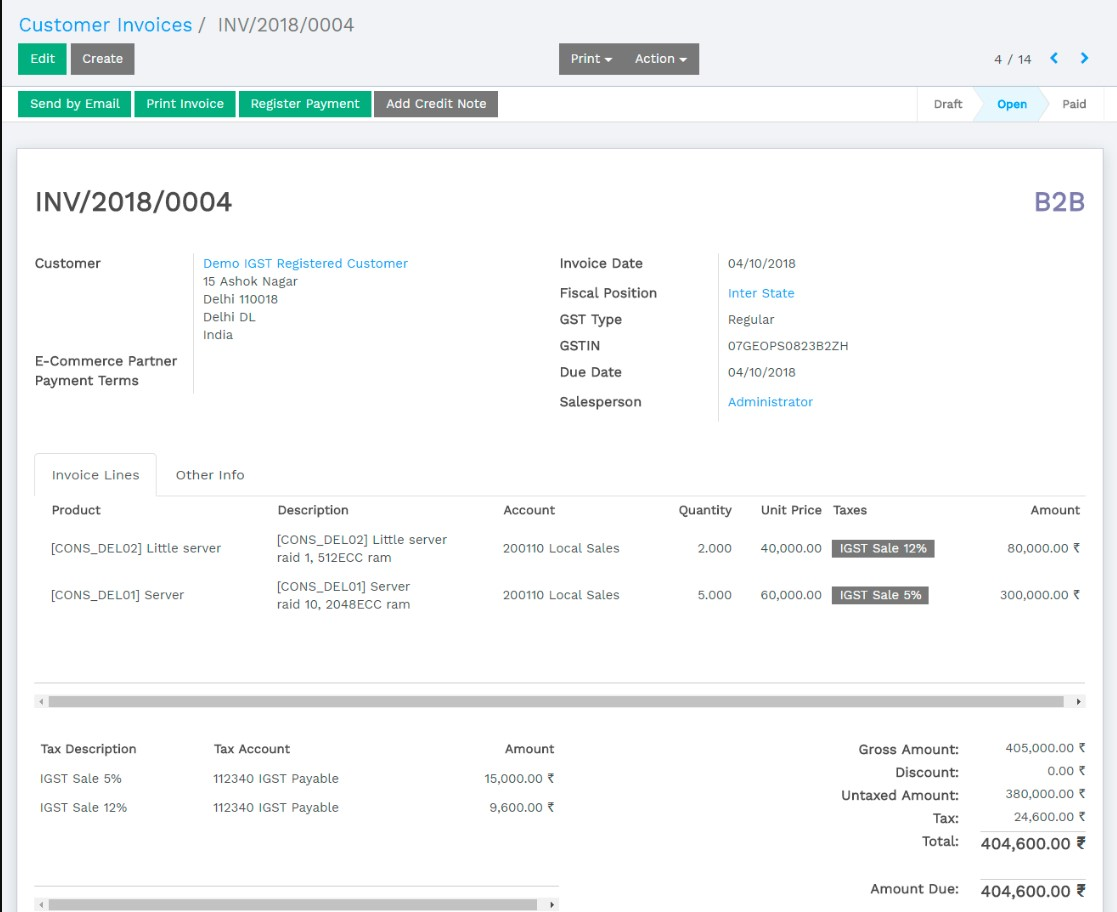

In [158]:
(w_container)